# Convolutional Autoencoder

Reconstruct and de-noise images from the MNIST dataset with an autoencode using convolutional layers.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


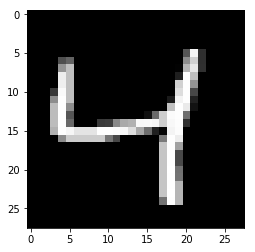

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')


### Decoder improvements

**Deconvolutional** layers like the tf.nn.conv2d_transpose api can produce artifacts in the final images, such as checkerboard patterns due to overlap in the kernels; these can be avoided by setting the stride and kernel size equal. The best way to avoid the atifacts is by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.


In [4]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='target')

### Encoder
conv1 = tf.layers.conv2d(inputs_, filters=16, strides=(1,1), kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, strides=(2,2), pool_size=(2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, filters=8, strides=(1,1), kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, strides=(2,2), pool_size=(2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, filters=8, strides=(1,1), kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, strides=(2,2), pool_size=(2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, filters=8, strides=(1,1), kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, filters=8, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, filters=16, strides=(1,1), kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, filters=1, strides=(1,1), kernel_size=(3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded1 = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

Instead of flattening the images, pass them in as 28x28x1 arrays so the 2d convolution picks up spatial relations in both dimensions.

In [5]:
sess1 = tf.Session()

In [6]:
epochs = 10
batch_size = 200
sess1.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess1.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10... Training loss: 0.1569
Epoch: 2/10... Training loss: 0.1343
Epoch: 3/10... Training loss: 0.1218
Epoch: 4/10... Training loss: 0.1201
Epoch: 5/10... Training loss: 0.1146
Epoch: 6/10... Training loss: 0.1081
Epoch: 7/10... Training loss: 0.1050
Epoch: 8/10... Training loss: 0.1083
Epoch: 9/10... Training loss: 0.1071
Epoch: 10/10... Training loss: 0.1034


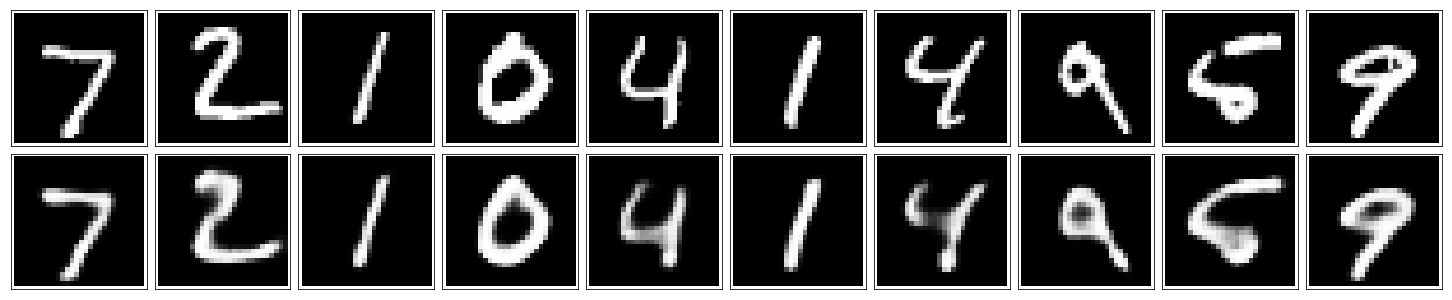

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess1.run(decoded1, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

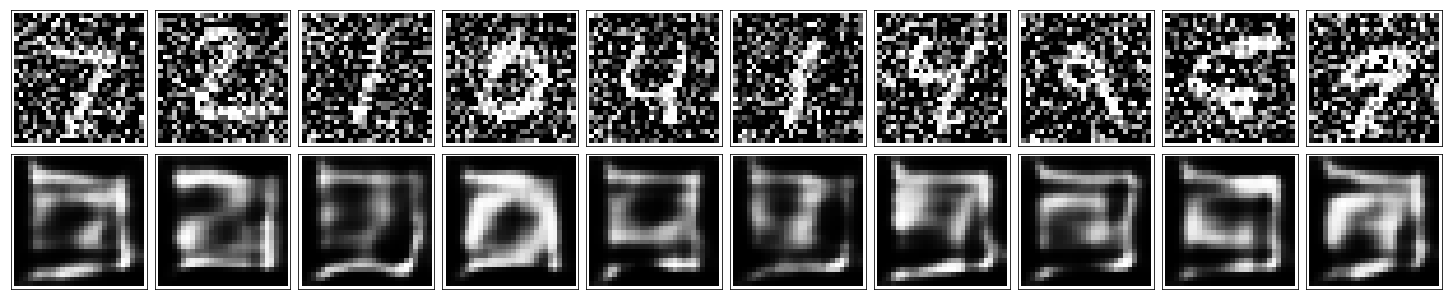

In [8]:
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess1.run(decoded1, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [9]:
learning_rate = 0.001
denoiser_inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='denoiser_inputs')
denoiser_targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='denoiser_targets')


### Encoder
conv1 = tf.layers.conv2d(denoiser_inputs_, filters=32, kernel_size=(3,3), 
                         strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 28x28 x 32

maxpool1 =  tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 14x14 x 32

conv2 = tf.layers.conv2d(maxpool1, filters=32, kernel_size=(3,3), 
                         strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 14x14 x 32

maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# Now 7x7 x 32

conv3 =  tf.layers.conv2d(maxpool2, filters=16, kernel_size=(3,3), 
                          strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 7x7 x 16



encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# Now 4x4 x 16



### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7 x 16

conv4 = tf.layers.conv2d(upsample1, filters=16, kernel_size=(3,3), 
                          strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 7x7 x 16

upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14, 14))
# Now 14x14 x 16

conv5 = tf.layers.conv2d(upsample2, filters=32, kernel_size=(3, 3),
                        strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 14x14 x 32

upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28, 28))
# Now 28x28 x 32

conv6 = tf.layers.conv2d(upsample3, filters=32, kernel_size=(3, 3),
                        strides=(1, 1), padding='same', activation=tf.nn.relu)
# Now 28x28 x 32

logits = tf.layers.conv2d(conv6, filters=1, kernel_size=(3, 3),
                         strides=(1, 1), padding='same', activation=None)
# Now 28x28 x 1

# Pass logits through sigmoid to get reconstructed image
denoiser_decoded = tf.nn.sigmoid(logits, name='denoiser_decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=denoiser_targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [10]:
sess2 = tf.Session()

In [11]:
epochs = 20
batch_size = 200

sess2.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess2.run([cost, opt], feed_dict={denoiser_inputs_: noisy_imgs,
                                                         denoiser_targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.1613
Epoch: 2/20... Training loss: 0.1407
Epoch: 3/20... Training loss: 0.1342
Epoch: 4/20... Training loss: 0.1272
Epoch: 5/20... Training loss: 0.1195
Epoch: 6/20... Training loss: 0.1205
Epoch: 7/20... Training loss: 0.1186
Epoch: 8/20... Training loss: 0.1184
Epoch: 9/20... Training loss: 0.1138
Epoch: 10/20... Training loss: 0.1140
Epoch: 11/20... Training loss: 0.1153
Epoch: 12/20... Training loss: 0.1121
Epoch: 13/20... Training loss: 0.1045
Epoch: 14/20... Training loss: 0.1097
Epoch: 15/20... Training loss: 0.1089
Epoch: 16/20... Training loss: 0.1098
Epoch: 17/20... Training loss: 0.1097
Epoch: 18/20... Training loss: 0.1072
Epoch: 19/20... Training loss: 0.1077
Epoch: 20/20... Training loss: 0.1025


## Checking out the performance

Adding gaussian noise to the test images and passing them through the autoencoders.

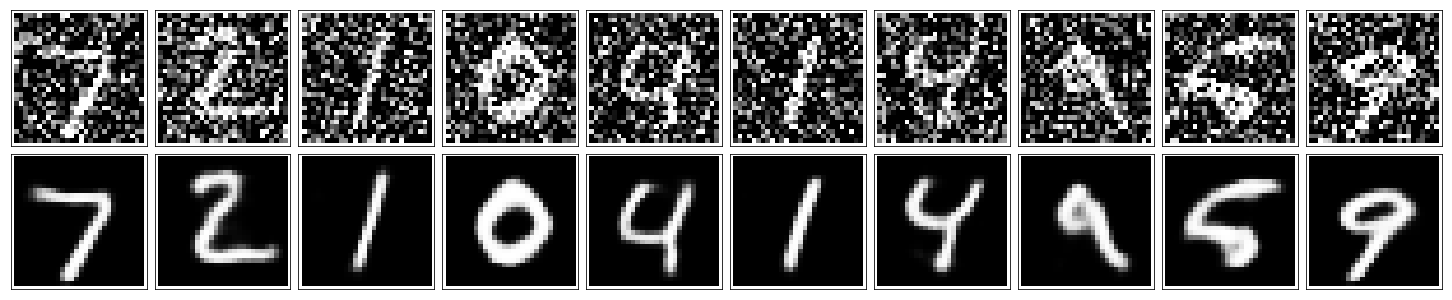

In [12]:
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

denoiser_reconstructed = sess2.run(denoiser_decoded, feed_dict={denoiser_inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, denoiser_reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)